In [14]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms, models, datasets
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from PIL import Image
import os
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(f"runs/testing")
!pwd
print(device)

cuda


'pwd' is not recognized as an internal or external command,
operable program or batch file.


In [35]:
def load_image(url, angle=0): 
    image = Image.open(url).rotate(angle)
    image = np.array(image)
    image = image / 255
    image = image.transpose((2, 0, 1))
    image = torch.from_numpy(image).float()
    return image

def load_train_data(batch_size=4, angles = [0], seed=42):
    train_x = [load_image(f'Resized_Dataset/train/{i}', ang) for ang in angles for i in os.listdir("Resized_Dataset/train")]
    train_y = [(0 if (i.split('_')[1])=="healthy.jpg" else 1) for _ in range(len(angles)) for i in os.listdir("Resized_Dataset/train")]
    train_x = torch.stack(train_x)
    train_y = torch.tensor(train_y)
    train_data = TensorDataset(train_x, train_y)
    torch.manual_seed(seed)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    return train_loader

def load_test_data(batch_size=40):
    test_x = [load_image(f'Resized_Dataset/test/{i}') for i in os.listdir("Resized_Dataset/test")]
    test_y = [(0 if (i.split('_')[1])=="healthy.jpg" else 1) for i in os.listdir("Resized_Dataset/test")]
    test_x = torch.stack(test_x)
    test_y = torch.tensor(test_y)
    test_data = TensorDataset(test_x, test_y)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    return test_loader


def accuracy(model, test_loader):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        loss = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            predicted = (torch.sigmoid(outputs) > 0.5).float().flatten()
            labels = labels.flatten()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss += (labels.size(0))*nn.BCEWithLogitsLoss()(outputs.flatten(), labels.float()).item()
    return correct / total, loss/total

def train(model, train_loader, test_loader, num_epochs=5, learning_rate=0.001, every=5):
    model = model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    total_step = len(train_loader)
    train_loss_list = []
    test_loss_list = []
    train_acc_list = []
    test_acc_list = []
    step = 0

    for epoch in range(num_epochs):
        model.train()
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs.flatten(), labels.float())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            test_acc, test_loss = accuracy(model, test_loader)
            train_acc, train_loss = accuracy(model, train_loader)
            if (i + 1) % every == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                      .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
            writer.add_scalar('Training Loss', loss, global_step=step)
            writer.add_scalar('Training Accuracy', train_acc, global_step=step)
            writer.add_scalar('Testing Accuracy', test_acc, global_step=step)
            step += 1
        test_acc, test_loss = accuracy(model, test_loader)
        train_acc, train_loss = accuracy(model, train_loader)
        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print('Train Accuracy: {}, Test Accuracy: {}'.format(train_acc_list[-1], test_acc_list[-1]))

    # Log 40 test images with labels at the end of training
    model.eval()
    with torch.no_grad():
        all_images = []
        all_labels = []
        all_predictions = []
        for test_images, test_labels in test_loader:
            test_images = test_images.to(device)
            outputs = model(test_images)
            predictions = torch.sigmoid(outputs).cpu().numpy()
            predictions = (predictions > 0.5).astype(int)
            all_images.append(test_images.cpu())
            all_labels.extend(test_labels.cpu().numpy())
            all_predictions.extend(predictions)
            if len(all_labels) >= 40:
                break

        all_images = torch.cat(all_images[:40], dim=0)  # Take the first 40 images
        all_labels = all_labels[:40]
        all_predictions = all_predictions[:40]

        # Plotting the labeled grid
        fig, axes = plt.subplots(5, 8, figsize=(15, 10))
        axes = axes.flatten()
        for idx, ax in enumerate(axes):
            img = all_images[idx].permute(1, 2, 0).numpy()  # Convert to HWC format
            ax.imshow(img)
            ax.axis('off')
            true_label = all_labels[idx]
            pred_label = all_predictions[idx][0]
            ax.set_title(f"T: {true_label} | P: {pred_label}", fontsize=8)
        plt.tight_layout()

        # Log the labeled grid to TensorBoard
        writer.add_figure('Test Images with Predictions', fig, global_step=step)

    return (train_loss_list, test_loss_list, train_acc_list, test_acc_list)




def view_misclassified(model, transfo=transforms.Compose([])): 
    # Viewing all misclassified images at once   
    test_paths = os.listdir("Resized_Dataset/test")
    fig = plt.figure(figsize=(20, 20))
    wrong_predictions = []
    predicted_labels = []
    actual_labels = []
    output_values = []
    model.eval()
    for path in test_paths:
        image = transfo(load_image(f'Resized_Dataset/test/{path}')).unsqueeze(0).to(device)
        label = 0 if (path.split('_')[1])=="healthy.jpg" else 1
        output = model(image)
        predicted = (torch.sigmoid(output) > 0.5).float().item()
        if predicted != label:
            #print(f"Predicted: {int(predicted)}, output: {round((torch.sigmoid(output)).item(), 2)} Actual: {label}")
            wrong_predictions.append(path)
            predicted_labels.append(predicted)
            actual_labels.append(label)
            output_values.append(round((torch.sigmoid(output)).item(), 2))
            #print(path)
            #display(Image.open(f'Resized_Dataset/test/{path}'))
            #print("")
    for i, path in enumerate(wrong_predictions):
        fig.add_subplot(4, 4, i+1)
        plt.imshow(Image.open(f'Resized_Dataset/test/{path}'))
        plt.title(f"Predicted: {predicted_labels[i]}, output: {output_values[i]} Actual: {actual_labels[i]}")
    plt.show()



In [36]:
# Making Dataloaders
train_loader = load_train_data(batch_size=16, angles=[0])
test_loader = load_test_data(batch_size=40)

In [37]:
# Defining models
class VGG1(nn.Module):
    def __init__(self):
        super(VGG1, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 10, kernel_size=3, padding=1),
            #nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # MLP layer
        self.mlp = nn.Sequential(
            nn.Flatten(),
            nn.Linear(10*112*112, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )
        self.params = (sum(p.numel() for p in self.parameters()))
    def forward(self, x):
        out = self.conv(x)
        out = self.mlp(out)
        return out
    
class VGG2(nn.Module):
    def __init__(self):
        super(VGG2, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 10, kernel_size=3, padding=1),
            #nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(10, 10, kernel_size=3, padding=1),
            #nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # MLP layer
        self.mlp = nn.Sequential(
            nn.Flatten(),
            nn.Linear(10*56*56, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )
    def forward(self, x):
        out = self.conv(x)
        out = self.mlp(out)
        return out
    
class VGG3(nn.Module):
    def __init__(self):
        super(VGG3, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 10, kernel_size=3, padding=1),
            #nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(10, 15, kernel_size=3, padding=1),
            #nn.BatchNorm2d(15),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(15, 20, kernel_size=3, padding=1),
            #nn.BatchNorm2d(20),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # MLP layer
        self.mlp = nn.Sequential(
            nn.Flatten(),
            nn.Linear(20*28*28, 20),
            nn.ReLU(),
            nn.Linear(20, 1)
        )
    def forward(self, x):
        out = self.conv(x)
        out = self.mlp(out)
        return out
    
class VGG4(nn.Module):
    def __init__(self):
        super(VGG4, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 10, kernel_size=3, padding=1),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(10, 10, kernel_size=3, padding=1),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(10, 10, kernel_size=3, padding=1),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(10, 10, kernel_size=3, padding=1),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # MLP layer
        self.layer2 = nn.Sequential(
            nn.Linear(10*14*14, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )
    def forward(self, x):
        out = self.layer1(x)
        out = out.view(out.size(0), -1)
        out = self.layer2(out)
        return out
    
class VGG16(nn.Module):
    def __init__(self, num_classes=2):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # MLP layer
        self.layer2 = nn.Sequential(
            nn.Linear(7*7*512, 4096),
            nn.ReLU(),

            nn.Linear(4096, 1000),
            nn.ReLU(),

            nn.Linear(1000, num_classes)
        )
    def forward(self, x):
        out = self.layer1(x)
        out = out.view(out.size(0), -1)
        out = self.layer2(out)
        return out

In [38]:
vgg1 = VGG1().to(device)
train_loss_list, test_loss_list, train_acc_list, test_acc_list = train(vgg1, train_loader, test_loader, num_epochs=20, learning_rate=0.001)

Epoch [1/20], Step [5/10], Loss: 0.7106
Epoch [1/20], Step [10/10], Loss: 0.7066
Train Accuracy: 0.55, Test Accuracy: 0.55
Epoch [2/20], Step [5/10], Loss: 0.6886
Epoch [2/20], Step [10/10], Loss: 0.6771
Train Accuracy: 0.61875, Test Accuracy: 0.725
Epoch [3/20], Step [5/10], Loss: 0.6749
Epoch [3/20], Step [10/10], Loss: 0.6503
Train Accuracy: 0.68125, Test Accuracy: 0.7
Epoch [4/20], Step [5/10], Loss: 0.6508
Epoch [4/20], Step [10/10], Loss: 0.5727
Train Accuracy: 0.71875, Test Accuracy: 0.775
Epoch [5/20], Step [5/10], Loss: 0.5491
Epoch [5/20], Step [10/10], Loss: 0.6434
Train Accuracy: 0.7125, Test Accuracy: 0.775
Epoch [6/20], Step [5/10], Loss: 0.5382
Epoch [6/20], Step [10/10], Loss: 0.6314
Train Accuracy: 0.80625, Test Accuracy: 0.775
Epoch [7/20], Step [5/10], Loss: 0.6297
Epoch [7/20], Step [10/10], Loss: 0.3684
Train Accuracy: 0.7, Test Accuracy: 0.65
Epoch [8/20], Step [5/10], Loss: 0.3922
Epoch [8/20], Step [10/10], Loss: 0.5760
Train Accuracy: 0.74375, Test Accuracy: 0.

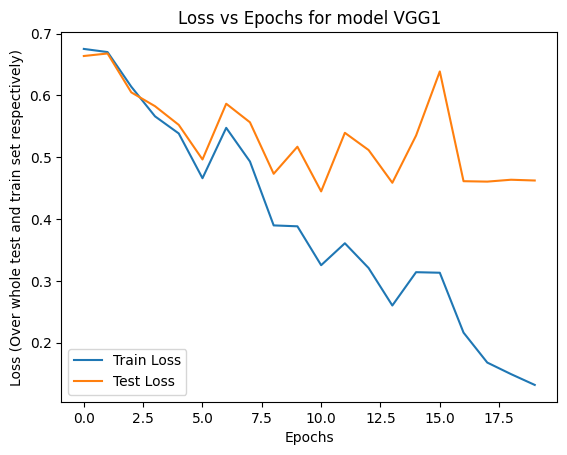

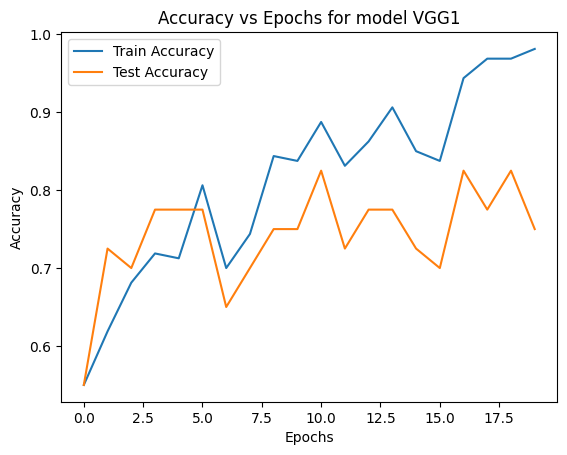

In [39]:
plt.title("Loss vs Epochs for model {}".format(vgg1.__class__.__name__))
plt.plot(train_loss_list, label='Train Loss')
plt.plot(test_loss_list, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (Over whole test and train set respectively)')
plt.legend()
plt.show()

plt.title("Accuracy vs Epochs for model {}".format(vgg1.__class__.__name__))
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(test_acc_list, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

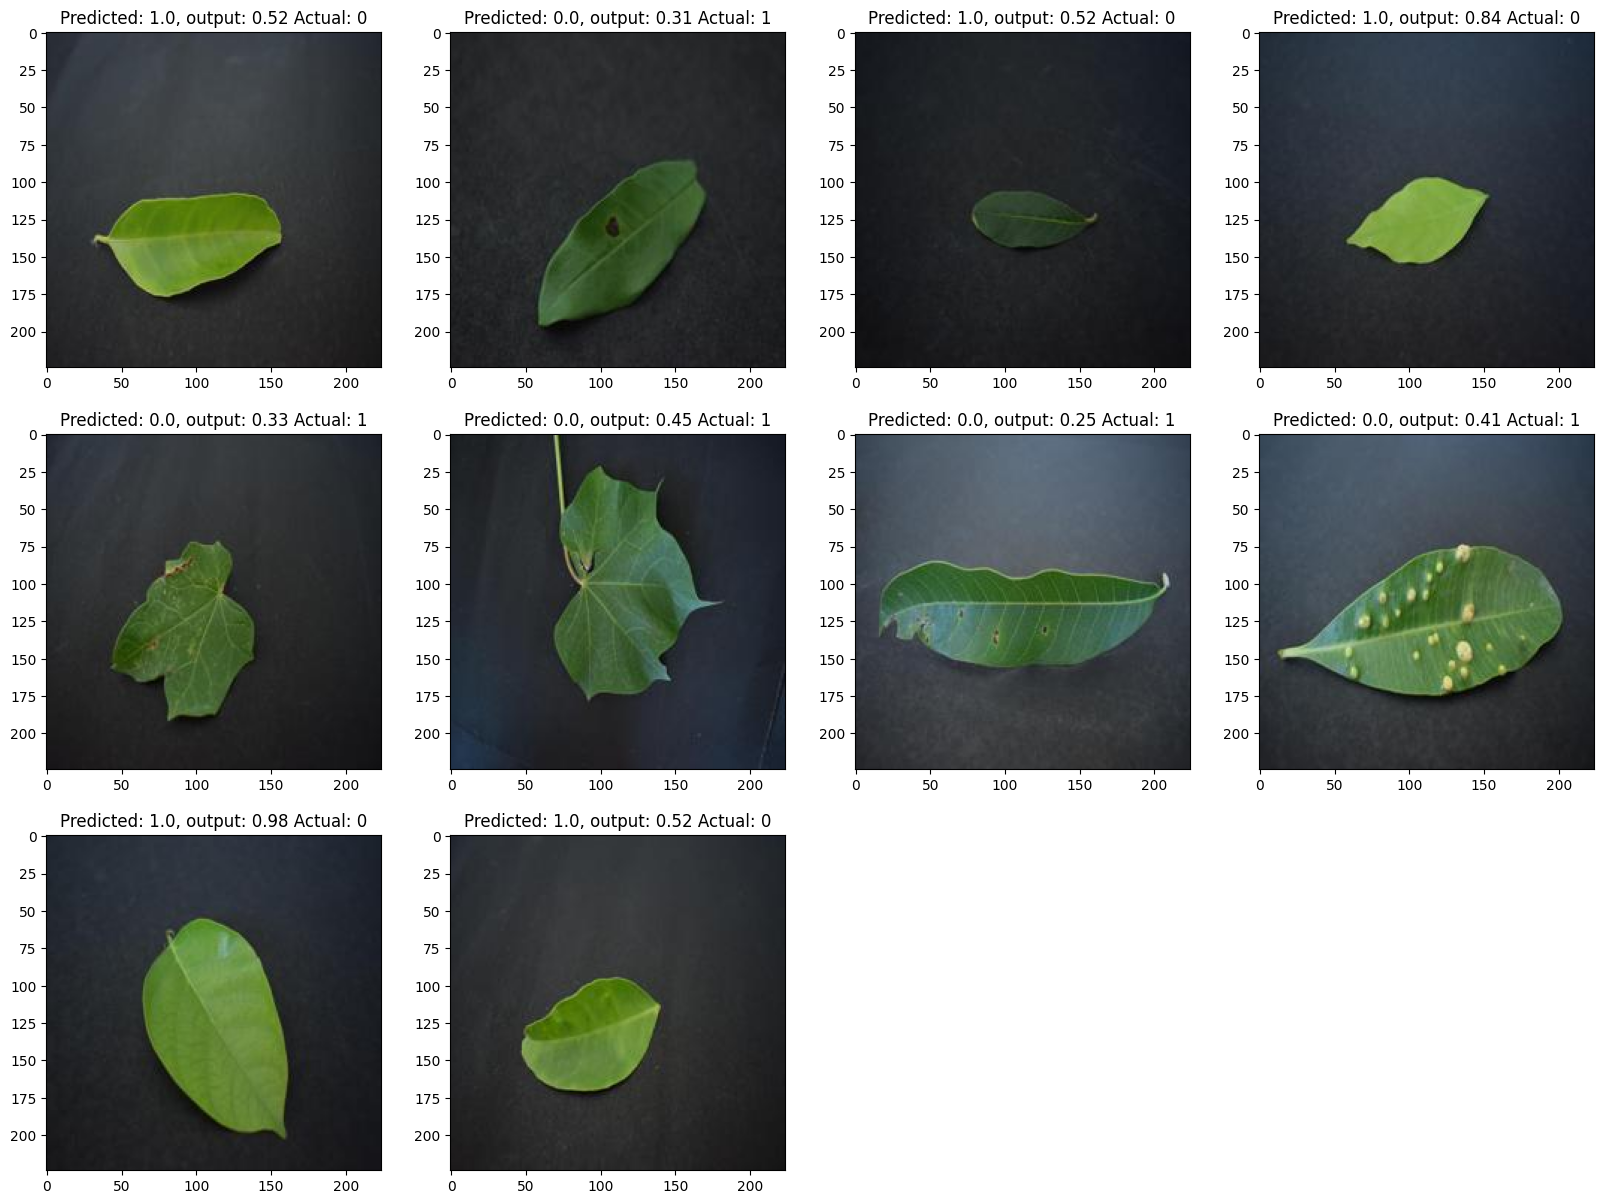

In [40]:
view_misclassified(vgg1)

In [41]:
vgg3 = VGG3().to(device)
train_loss_list, test_loss_list, train_acc_list, test_acc_list = train(vgg3, train_loader, test_loader, num_epochs=40, learning_rate=0.001, every=10)


Epoch [1/40], Step [10/10], Loss: 0.6868
Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch [2/40], Step [10/10], Loss: 0.6888
Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch [3/40], Step [10/10], Loss: 0.6993
Train Accuracy: 0.5, Test Accuracy: 0.525
Epoch [4/40], Step [10/10], Loss: 0.6862
Train Accuracy: 0.64375, Test Accuracy: 0.675
Epoch [5/40], Step [10/10], Loss: 0.6932
Train Accuracy: 0.58125, Test Accuracy: 0.625
Epoch [6/40], Step [10/10], Loss: 0.6944
Train Accuracy: 0.58125, Test Accuracy: 0.6
Epoch [7/40], Step [10/10], Loss: 0.6308
Train Accuracy: 0.64375, Test Accuracy: 0.625
Epoch [8/40], Step [10/10], Loss: 0.6121
Train Accuracy: 0.725, Test Accuracy: 0.75
Epoch [9/40], Step [10/10], Loss: 0.5910
Train Accuracy: 0.69375, Test Accuracy: 0.725
Epoch [10/40], Step [10/10], Loss: 0.6224
Train Accuracy: 0.5625, Test Accuracy: 0.525
Epoch [11/40], Step [10/10], Loss: 0.7355
Train Accuracy: 0.675, Test Accuracy: 0.65
Epoch [12/40], Step [10/10], Loss: 0.5968
Train Accuracy: 0.79375,

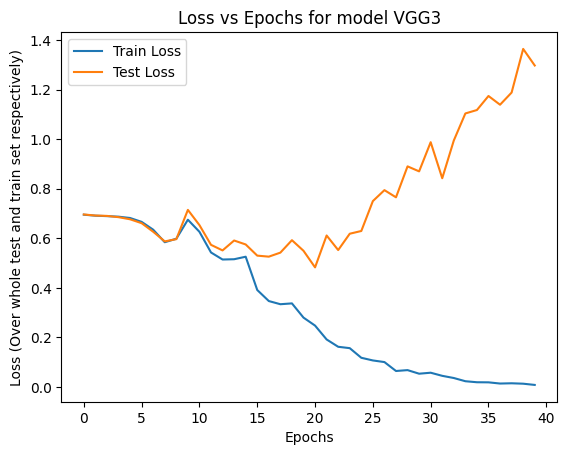

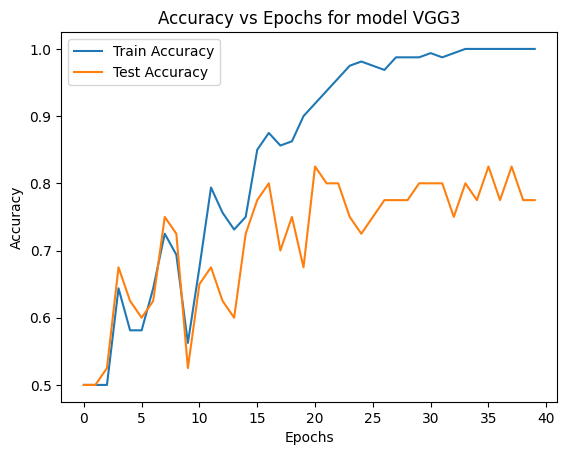

In [42]:
plt.title("Loss vs Epochs for model {}".format(vgg3.__class__.__name__))
plt.plot(train_loss_list, label='Train Loss')
plt.plot(test_loss_list, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (Over whole test and train set respectively)')
plt.legend()
plt.show()

plt.title("Accuracy vs Epochs for model {}".format(vgg3.__class__.__name__))
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(test_acc_list, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

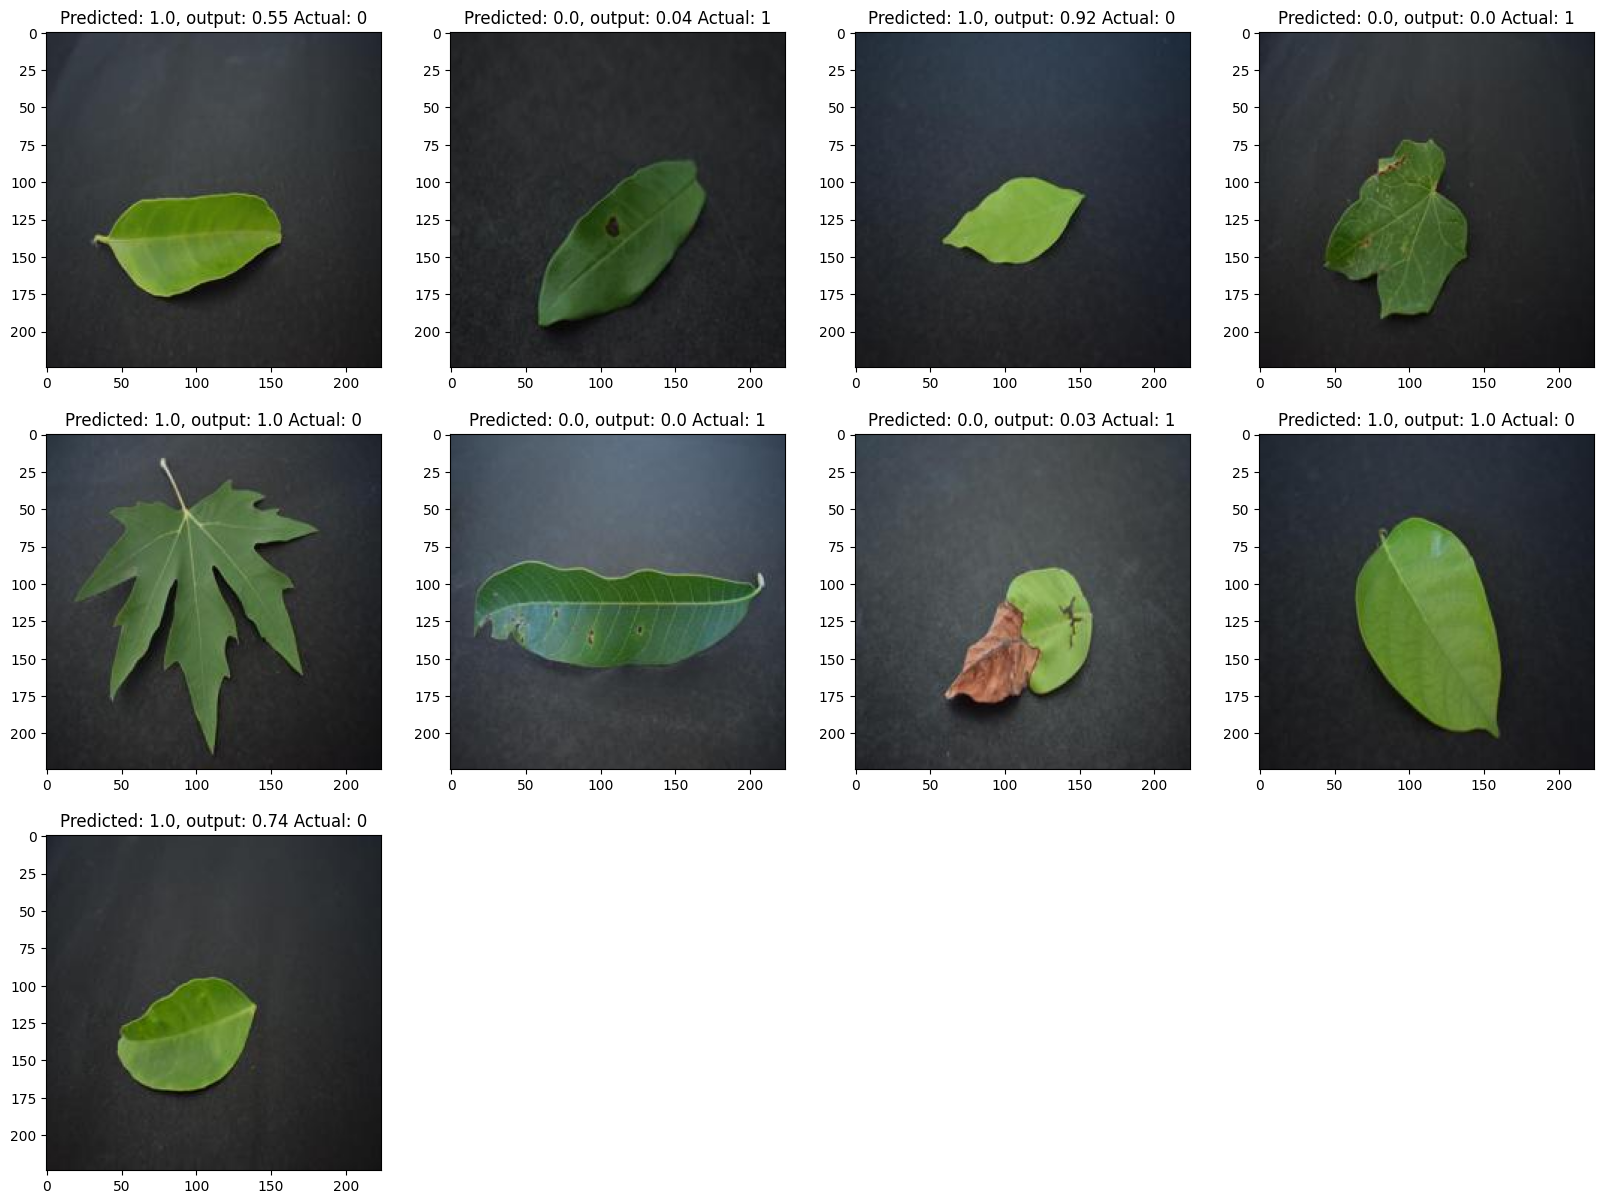

In [43]:
view_misclassified(vgg3)

In [44]:

aug_train_loader = load_train_data(batch_size=8, angles=[0, 90, 180, 270], seed=10)
vgg3_aug = VGG3().to(device)
train_loss_list, test_loss_list, train_acc_list, test_acc_list = train(vgg3_aug, aug_train_loader, test_loader, num_epochs=40, learning_rate=0.001, every=40)


Epoch [1/40], Step [40/80], Loss: 0.6980
Epoch [1/40], Step [80/80], Loss: 0.7083
Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch [2/40], Step [40/80], Loss: 0.6881
Epoch [2/40], Step [80/80], Loss: 0.6816
Train Accuracy: 0.596875, Test Accuracy: 0.6
Epoch [3/40], Step [40/80], Loss: 0.6934
Epoch [3/40], Step [80/80], Loss: 0.6883
Train Accuracy: 0.603125, Test Accuracy: 0.6
Epoch [4/40], Step [40/80], Loss: 0.5080
Epoch [4/40], Step [80/80], Loss: 0.7201
Train Accuracy: 0.503125, Test Accuracy: 0.5
Epoch [5/40], Step [40/80], Loss: 0.7032
Epoch [5/40], Step [80/80], Loss: 0.6609
Train Accuracy: 0.6140625, Test Accuracy: 0.55
Epoch [6/40], Step [40/80], Loss: 0.7469
Epoch [6/40], Step [80/80], Loss: 0.6306
Train Accuracy: 0.64375, Test Accuracy: 0.625
Epoch [7/40], Step [40/80], Loss: 0.4686
Epoch [7/40], Step [80/80], Loss: 0.6954
Train Accuracy: 0.6234375, Test Accuracy: 0.625
Epoch [8/40], Step [40/80], Loss: 0.6016
Epoch [8/40], Step [80/80], Loss: 0.4996
Train Accuracy: 0.628125, Te

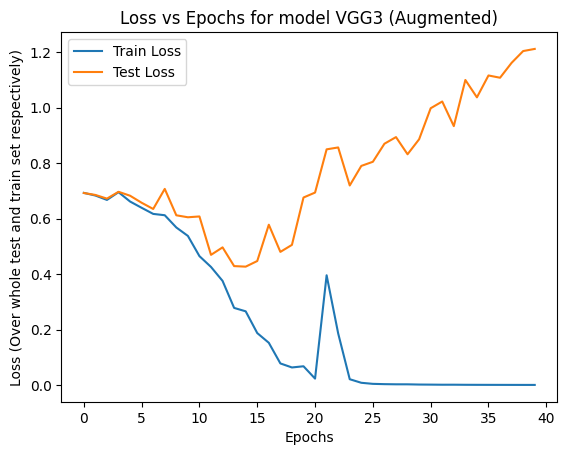

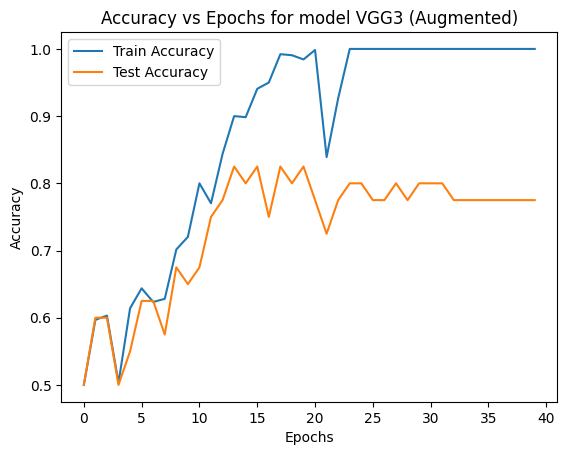

In [45]:
plt.title("Loss vs Epochs for model {} (Augmented)".format(vgg3_aug.__class__.__name__))
plt.plot(train_loss_list, label='Train Loss')
plt.plot(test_loss_list, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (Over whole test and train set respectively)')
plt.legend()
plt.show()

plt.title("Accuracy vs Epochs for model {} (Augmented)".format(vgg3_aug.__class__.__name__))
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(test_acc_list, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

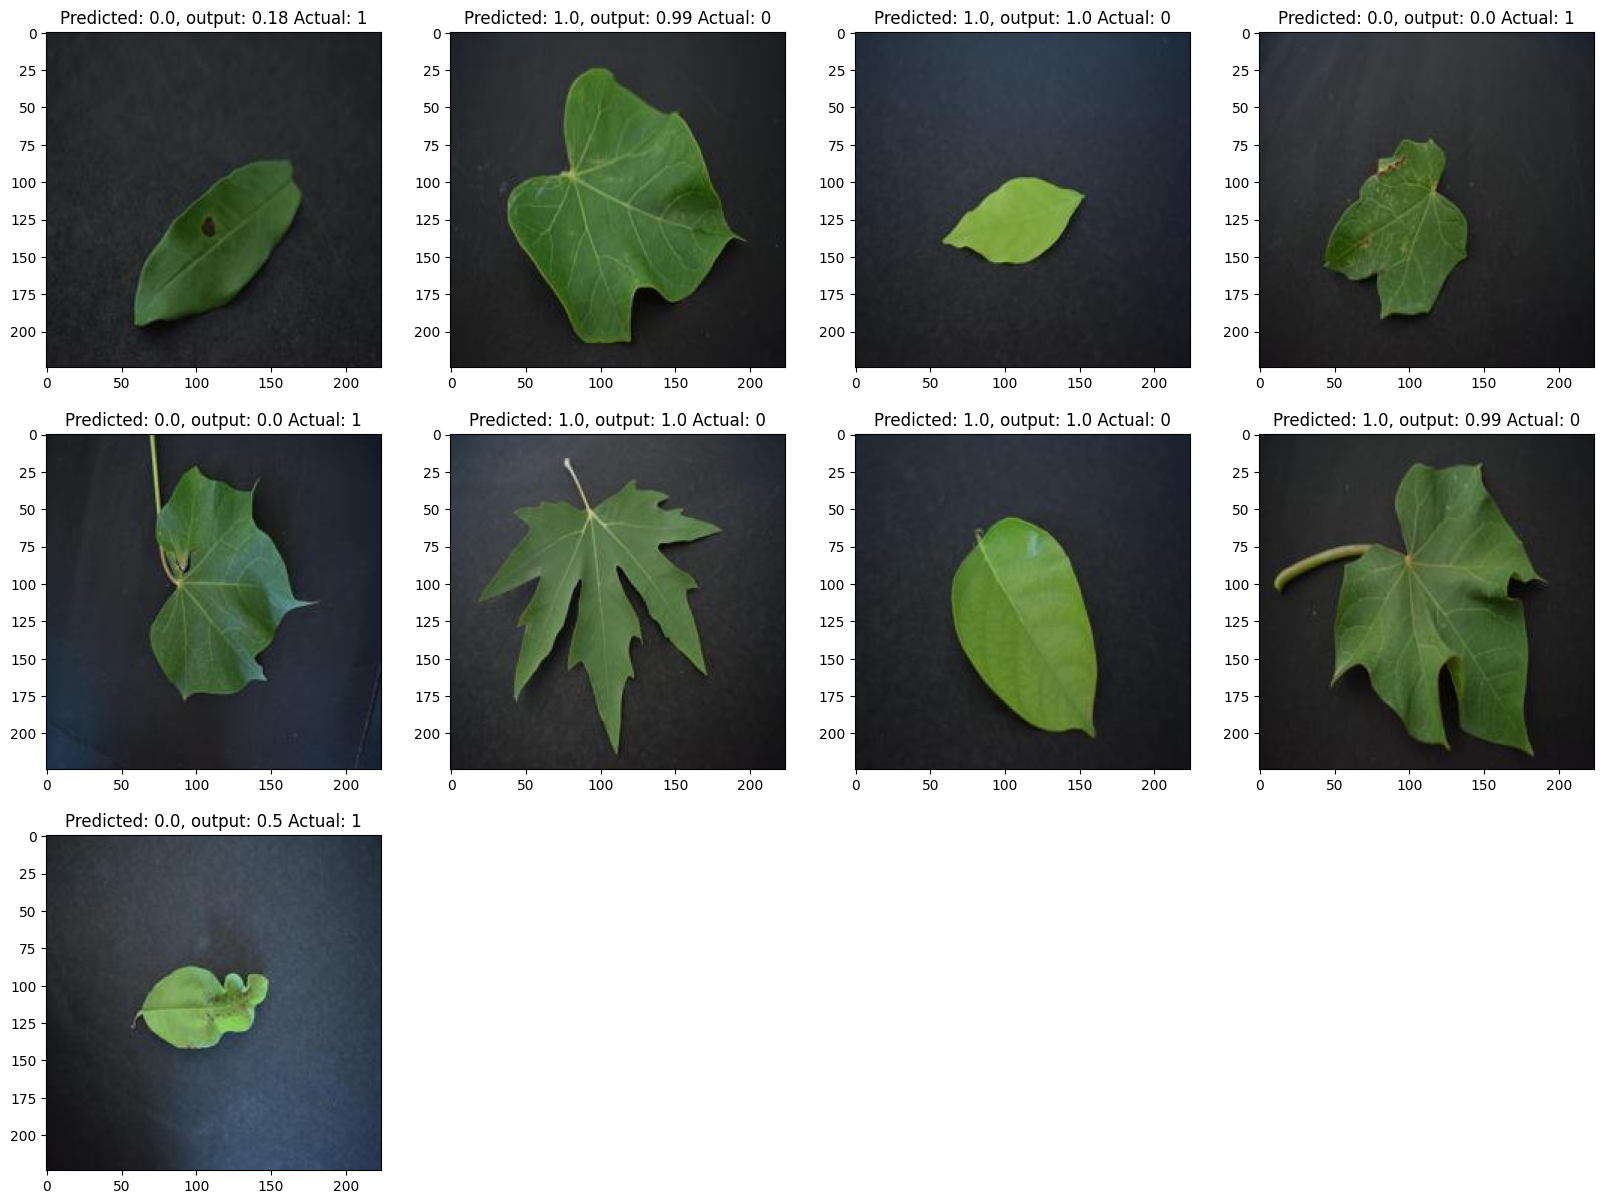

In [46]:
view_misclassified(vgg3_aug)

In [49]:
# Define the preprocessing transformations
transform = transforms.Compose([
    #transforms.ToTensor(),                 # Convert the image to a PyTorch tensor (range 0 to 1)
    transforms.Normalize(                  # Normalize using ImageNet statistics
        mean=[0.485, 0.456, 0.406],        # Mean for ImageNet
        std=[0.229, 0.224, 0.225]          # Std for ImageNet
    ),
])

# Apply the transformations to the image
train_x = [transform(load_image(f'Resized_Dataset/train/{i}')) for i in os.listdir("Resized_Dataset/train")]
train_y = [(0 if (i.split('_')[1])=="healthy.jpg" else 1) for i in os.listdir("Resized_Dataset/train")]
train_x = torch.stack(train_x)
train_y = torch.tensor(train_y)
train_data = TensorDataset(train_x, train_y)
torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size=8, shuffle=True)

test_x = [transform(load_image(f'Resized_Dataset/test/{i}')) for i in os.listdir("Resized_Dataset/test")]
test_y = [(0 if (i.split('_')[1])=="healthy.jpg" else 1) for i in os.listdir("Resized_Dataset/test")]
test_x = torch.stack(test_x)
test_y = torch.tensor(test_y)
test_data = TensorDataset(test_x, test_y)
torch.manual_seed(42)
test_loader = DataLoader(test_data, batch_size=40, shuffle=False)

In [50]:
# Tuning all layers
vgg16 = models.vgg16(pretrained=True)
# Replacing the MLP layer of vgg16 with a lightweight new one with 1 output 
vgg16.classifier[6] = nn.Sequential(
    nn.Linear(4096, 512),
    nn.ReLU(),
    nn.Linear(512, 1)
)
vgg16 = vgg16.to(device)
#train_loader = load_train_data(batch_size=1, angles=[0], seed=42)
train_loss_list, test_loss_list, train_acc_list, test_acc_list = train(vgg16, train_loader, test_loader, num_epochs=40, learning_rate=1e-3, every=10)

c:\Users\Arjun\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Arjun\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\Arjun/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|██████████| 528M/528M [00:58<00:00, 9.39MB/s] 


Epoch [1/40], Step [10/20], Loss: 0.7069
Epoch [1/40], Step [20/20], Loss: 0.6889
Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch [2/40], Step [10/20], Loss: 0.6927
Epoch [2/40], Step [20/20], Loss: 0.6930
Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch [3/40], Step [10/20], Loss: 0.6994
Epoch [3/40], Step [20/20], Loss: 0.7476
Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch [4/40], Step [10/20], Loss: 0.6998
Epoch [4/40], Step [20/20], Loss: 0.6931
Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch [5/40], Step [10/20], Loss: 0.6922
Epoch [5/40], Step [20/20], Loss: 0.6933
Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch [6/40], Step [10/20], Loss: 0.6932
Epoch [6/40], Step [20/20], Loss: 0.6931
Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch [7/40], Step [10/20], Loss: 0.6931
Epoch [7/40], Step [20/20], Loss: 0.6931
Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch [8/40], Step [10/20], Loss: 0.6932
Epoch [8/40], Step [20/20], Loss: 0.6931
Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch [9/40], Step [10/2

KeyboardInterrupt: 

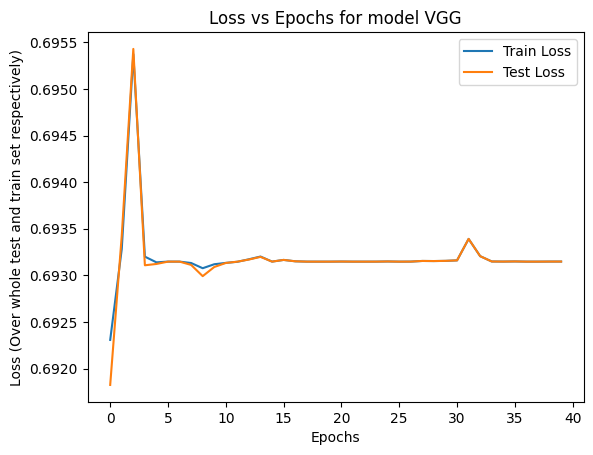

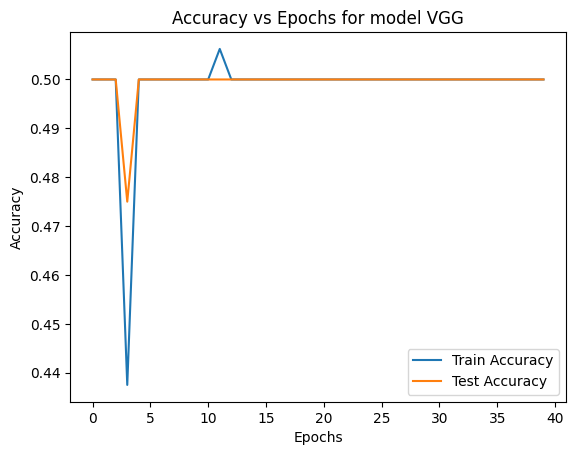

In [15]:
plt.title("Loss vs Epochs for model {}".format(vgg16.__class__.__name__))
plt.plot(train_loss_list, label='Train Loss')
plt.plot(test_loss_list, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (Over whole test and train set respectively)')
plt.legend()
plt.show()

plt.title("Accuracy vs Epochs for model {}".format(vgg16.__class__.__name__))
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(test_acc_list, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [16]:
# Tuning all layers
vgg16 = models.vgg16(pretrained=True)
# Replacing the MLP layer of vgg16 with a lightweight new one with 1 output 
for param in vgg16.parameters():
    param.requires_grad = False  # Freeze the convolutional layers


vgg16.classifier[6] = nn.Sequential(
    nn.Linear(4096, 20),
    nn.ReLU(),
    nn.Linear(20, 1)
)
vgg16 = vgg16.to(device)
#train_loader = load_train_data(batch_size=1, angles=[0], seed=42)
train_loss_list, test_loss_list, train_acc_list, test_acc_list = train(vgg16, train_loader, test_loader, num_epochs=40, learning_rate=0.001, every=10)

Epoch [1/40], Step [10/20], Loss: 0.5509
Epoch [1/40], Step [20/20], Loss: 0.7265


Train Accuracy: 0.75, Test Accuracy: 0.85
Epoch [2/40], Step [10/20], Loss: 0.5887
Epoch [2/40], Step [20/20], Loss: 0.4293
Train Accuracy: 0.75, Test Accuracy: 0.75
Epoch [3/40], Step [10/20], Loss: 0.5979
Epoch [3/40], Step [20/20], Loss: 0.6357
Train Accuracy: 0.7875, Test Accuracy: 0.8
Epoch [4/40], Step [10/20], Loss: 0.6578
Epoch [4/40], Step [20/20], Loss: 0.5775
Train Accuracy: 0.8375, Test Accuracy: 0.925
Epoch [5/40], Step [10/20], Loss: 0.4381
Epoch [5/40], Step [20/20], Loss: 0.4932
Train Accuracy: 0.8875, Test Accuracy: 0.925
Epoch [6/40], Step [10/20], Loss: 0.4493
Epoch [6/40], Step [20/20], Loss: 0.3970
Train Accuracy: 0.8625, Test Accuracy: 0.925
Epoch [7/40], Step [10/20], Loss: 0.4252
Epoch [7/40], Step [20/20], Loss: 0.2676
Train Accuracy: 0.8125, Test Accuracy: 0.85
Epoch [8/40], Step [10/20], Loss: 0.4308
Epoch [8/40], Step [20/20], Loss: 0.2671
Train Accuracy: 0.925, Test Accuracy: 0.95
Epoch [9/40], Step [10/20], Loss: 0.5568
Epoch [9/40], Step [20/20], Loss: 0.

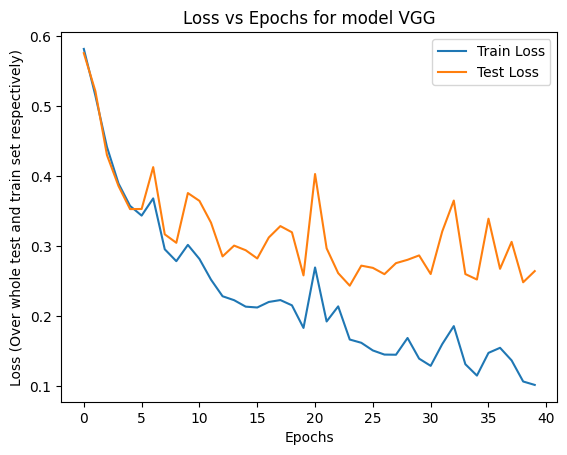

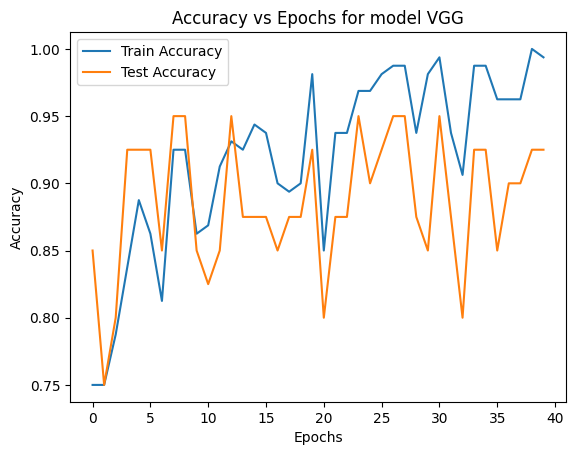

In [17]:
plt.title("Loss vs Epochs for model {}".format(vgg16.__class__.__name__))
plt.plot(train_loss_list, label='Train Loss')
plt.plot(test_loss_list, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (Over whole test and train set respectively)')
plt.legend()
plt.show()

plt.title("Accuracy vs Epochs for model {}".format(vgg16.__class__.__name__))
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(test_acc_list, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

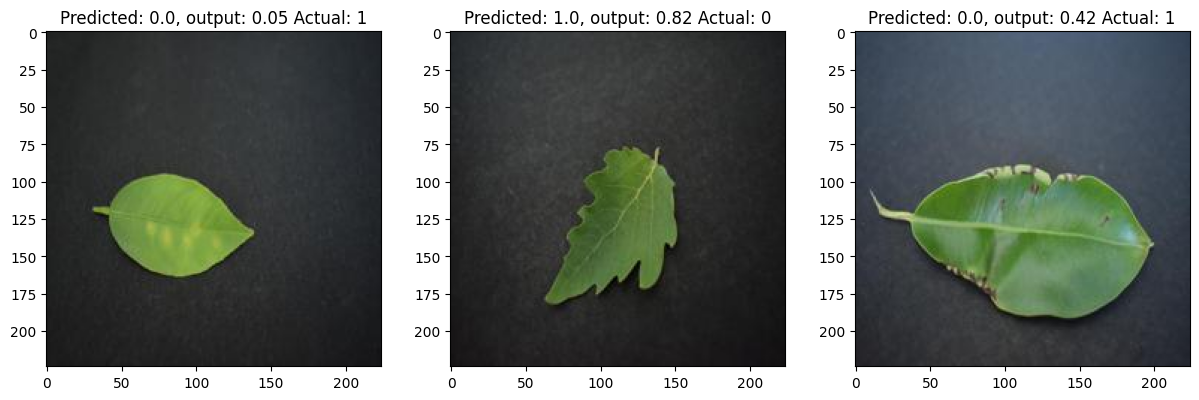

In [20]:
view_misclassified(vgg16, transform)